# Analisi della Qualità dell'Aria - Machine Learning Supervisionato

## 1. Importazione delle Librerie

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

# Per la visualizzazione
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 2. Caricamento e Esplorazione Iniziale dei Dati

In [3]:
# Caricamento del dataset
df = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')

print("Dimensioni del dataset:", df.shape)
print("\nPrime righe del dataset:")
df.head()

Dimensioni del dataset: (9471, 17)

Prime righe del dataset:


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [4]:
# Informazioni generali sul dataset
df.info()

print("\nColonne del dataset:")
for i, col in enumerate(df.columns):
    print(f"{i+1}. {col}")

Informazioni sul dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)


## 3. Pulizia e Preprocessing dei Dati

In [5]:
# Rimozione delle colonne vuote
df = df.dropna(axis=1, how='all')

# Creazione della colonna datetime
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S')

# Sostituzione dei valori -200 con NaN (valori mancanti)
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].replace(-200, np.nan)

print(f"Dimensioni: {df.shape}")
print(df.isnull().sum())

Dataset dopo la pulizia iniziale:
Dimensioni: (9471, 16)
Valori mancanti per colonna:
Date              114
Time              114
CO(GT)           1797
PT08.S1(CO)       480
NMHC(GT)         8557
C6H6(GT)          480
PT08.S2(NMHC)     480
NOx(GT)          1753
PT08.S3(NOx)      480
NO2(GT)          1756
PT08.S4(NO2)      480
PT08.S5(O3)       480
T                 480
RH                480
AH                480
DateTime          114
dtype: int64


In [6]:
# Analisi degli inquinanti principali
pollutants = ['CO(GT)', 'NO2(GT)', 'NOx(GT)', 'C6H6(GT)']
available_pollutants = [col for col in pollutants if col in df.columns]

for pol in available_pollutants:
    missing_pct = (df[pol].isnull().sum() / len(df)) * 100
    print(f"- {pol}: {missing_pct:.1f}% valori mancanti")

# Selezioniamo CO(GT) come inquinante principale per l'analisi
target_pollutant = 'CO(GT)'

Inquinanti disponibili per l'analisi:
- CO(GT): 19.0% valori mancanti
- NO2(GT): 18.5% valori mancanti
- NOx(GT): 18.5% valori mancanti
- C6H6(GT): 5.1% valori mancanti

Inquinante selezionato per l'analisi: CO(GT)


In [7]:
# Rimozione delle righe con valori mancanti per l'inquinante target
df_clean = df.dropna(subset=[target_pollutant]).copy()

# Aggiunta di colonne temporali per l'analisi
df_clean['Hour'] = df_clean['DateTime'].dt.hour
df_clean['Day'] = df_clean['DateTime'].dt.day
df_clean['Month'] = df_clean['DateTime'].dt.month
df_clean['Weekday'] = df_clean['DateTime'].dt.dayofweek
df_clean['Week'] = df_clean['DateTime'].dt.isocalendar().week

print(f"Periodo temporale: da {df_clean['DateTime'].min()} a {df_clean['DateTime'].max()}")

Dataset finale per l'analisi: (7674, 21)
Periodo temporale: da 2004-03-10 18:00:00 a 2005-04-04 14:00:00


## 4. Analisi Esplorativa dei Dati (EDA)

Statistiche descrittive per CO(GT):
count    7674.000000
mean        2.152750
std         1.453252
min         0.100000
25%         1.100000
50%         1.800000
75%         2.900000
max        11.900000
Name: CO(GT), dtype: float64


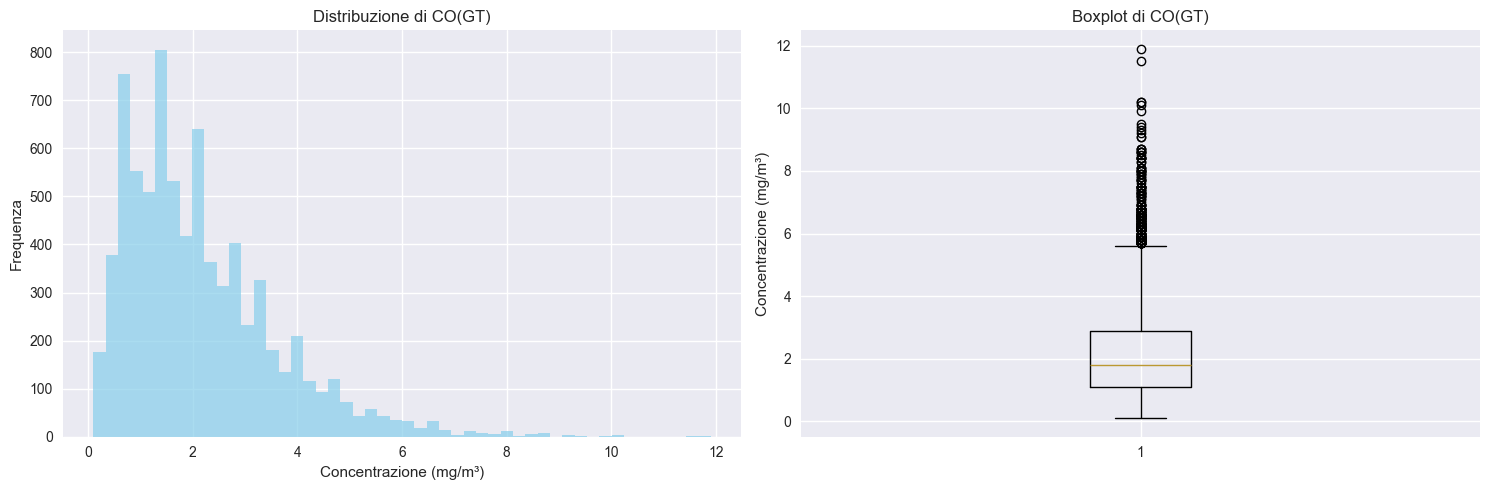

In [8]:
# Statistiche descrittive dell'inquinante principale
print(f"Statistiche descrittive per {target_pollutant}:")
print(df_clean[target_pollutant].describe())

# Visualizzazione della distribuzione
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Istogramma
axes[0].hist(df_clean[target_pollutant], bins=50, alpha=0.7, color='skyblue')
axes[0].set_title(f'Distribuzione di {target_pollutant}')
axes[0].set_xlabel('Concentrazione (mg/m³)')
axes[0].set_ylabel('Frequenza')

# Boxplot
axes[1].boxplot(df_clean[target_pollutant])
axes[1].set_title(f'Boxplot di {target_pollutant}')
axes[1].set_ylabel('Concentrazione (mg/m³)')

plt.tight_layout()
plt.show()

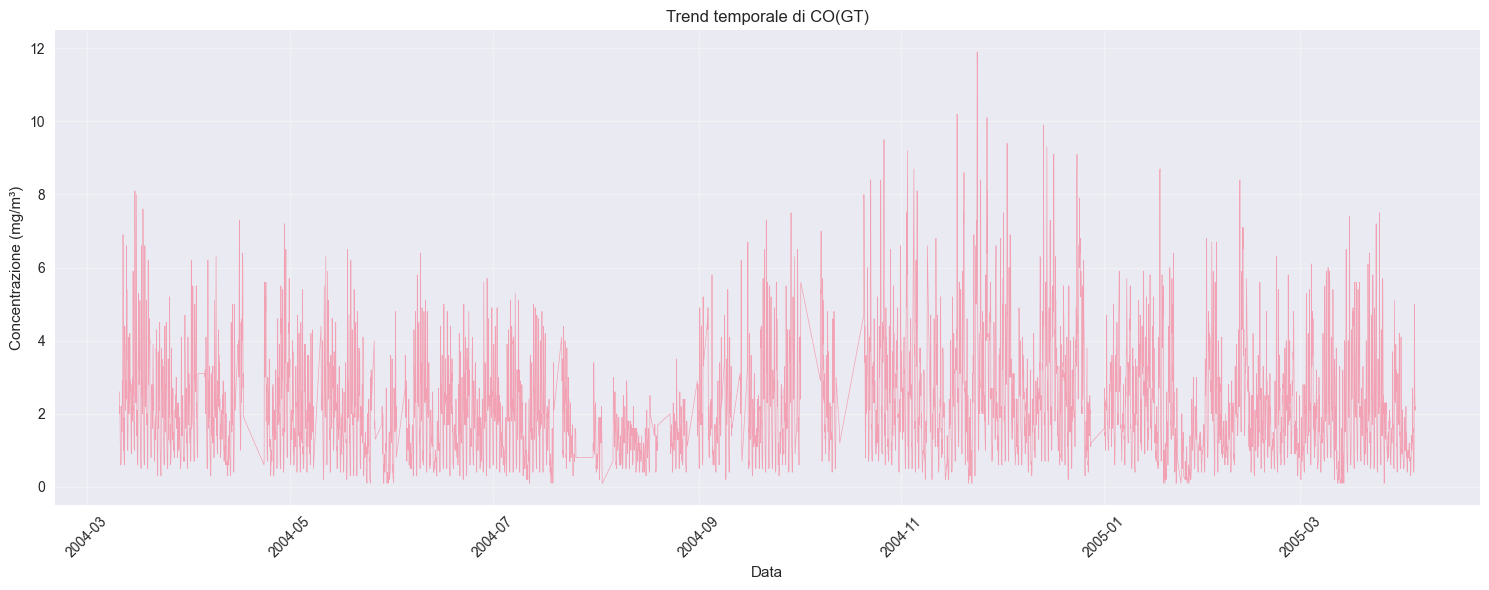

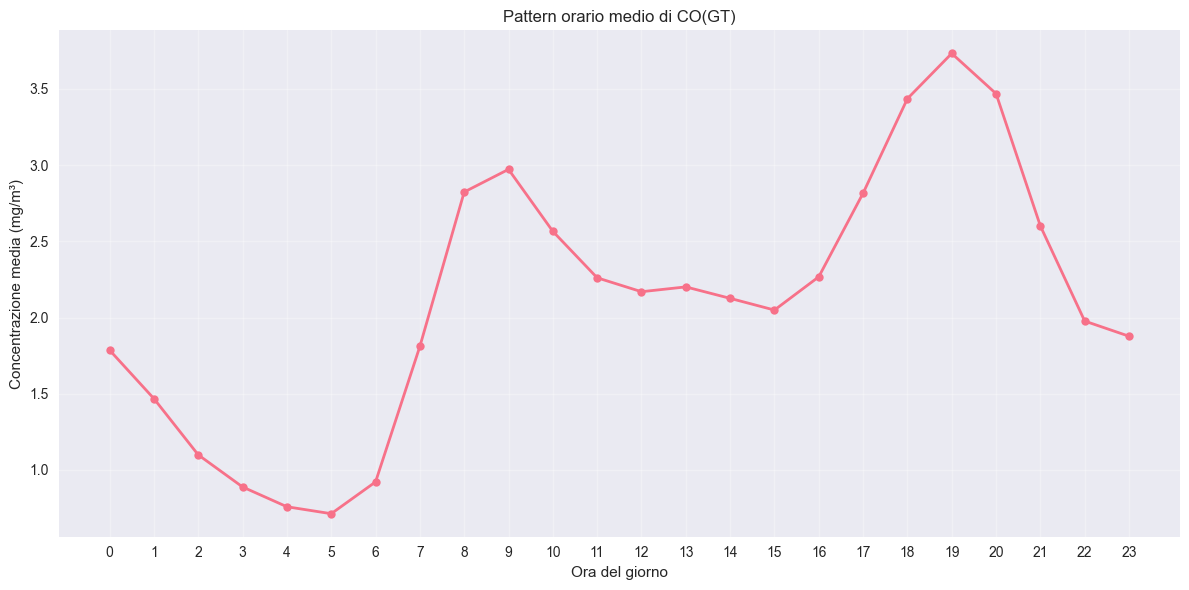

In [9]:
# Trend temporale dell'inquinante
plt.figure(figsize=(15, 6))
plt.plot(df_clean['DateTime'], df_clean[target_pollutant], alpha=0.6, linewidth=0.5)
plt.title(f'Trend temporale di {target_pollutant}')
plt.xlabel('Data')
plt.ylabel('Concentrazione (mg/m³)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Pattern orario
hourly_avg = df_clean.groupby('Hour')[target_pollutant].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2, markersize=6)
plt.title(f'Pattern orario medio di {target_pollutant}')
plt.xlabel('Ora del giorno')
plt.ylabel('Concentrazione media (mg/m³)')
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

## 5. Creazione delle Variabili Target per la Classificazione

### 5.1 Classificazione basata sulla Media Giornaliera

In [10]:
# Calcolo delle medie per la classificazione
df_clean['Date_only'] = df_clean['DateTime'].dt.date

# Media giornaliera
daily_means = df_clean.groupby('Date_only')[target_pollutant].mean()
df_clean['daily_mean'] = df_clean['Date_only'].map(daily_means)

# Media settimanale
weekly_means = df_clean.groupby('Week')[target_pollutant].mean()
df_clean['weekly_mean'] = df_clean['Week'].map(weekly_means)

# Media complessiva
overall_mean = df_clean[target_pollutant].mean()
df_clean['overall_mean'] = overall_mean

print(f"Media complessiva di {target_pollutant}: {overall_mean:.3f} mg/m³")
print(f"Mediana: {df_clean[target_pollutant].median():.3f} mg/m³")
print(f"Deviazione standard: {df_clean[target_pollutant].std():.3f} mg/m³")

Media complessiva di CO(GT): 2.153 mg/m³
Mediana: 1.800 mg/m³
Deviazione standard: 1.453 mg/m³


In [11]:
# Creazione delle variabili target per la classificazione
# 1 = Scarsa qualità dell'aria, 0 = Buona qualità dell'aria

df_clean['quality_vs_daily'] = (df_clean[target_pollutant] > df_clean['daily_mean']).astype(int)
df_clean['quality_vs_weekly'] = (df_clean[target_pollutant] > df_clean['weekly_mean']).astype(int)
df_clean['quality_vs_overall'] = (df_clean[target_pollutant] > df_clean['overall_mean']).astype(int)

# Analisi della distribuzione delle classi
print("Distribuzione delle classi di qualità dell'aria:")
print("\n1. Confronto con media giornaliera:")
print(df_clean['quality_vs_daily'].value_counts(normalize=True))

print("\n2. Confronto con media settimanale:")
print(df_clean['quality_vs_weekly'].value_counts(normalize=True))

print("\n3. Confronto con media complessiva:")
print(df_clean['quality_vs_overall'].value_counts(normalize=True))

Distribuzione delle classi di qualità dell'aria:

1. Confronto con media giornaliera:
quality_vs_daily
0    0.545087
1    0.454913
Name: proportion, dtype: float64

2. Confronto con media settimanale:
quality_vs_weekly
0    0.566198
1    0.433802
Name: proportion, dtype: float64

3. Confronto con media complessiva:
quality_vs_overall
0    0.594735
1    0.405265
Name: proportion, dtype: float64


## 6. Identificazione delle Ore di Picco

In [12]:
# Identificazione delle 3 ore di picco per ogni giorno
def identify_peak_hours(group):
    """
    Identifica le 3 ore con i valori più alti di inquinante per ogni giorno
    """
    top_3 = group.nlargest(3, target_pollutant)
    return top_3.index

# Applicazione della funzione per ogni giorno
peak_hours_indices = []
for date, group in df_clean.groupby('Date_only'):
    if len(group) >= 3:  # Assicuriamoci di avere almeno 3 misurazioni per giorno
        peak_indices = identify_peak_hours(group)
        peak_hours_indices.extend(peak_indices)

# Creazione della colonna per le ore di picco
df_clean['is_peak_hour'] = 0
df_clean.loc[peak_hours_indices, 'is_peak_hour'] = 1

print(f"Totale ore di picco identificate: {df_clean['is_peak_hour'].sum()}")
print(f"Percentuale di ore di picco: {(df_clean['is_peak_hour'].sum() / len(df_clean)) * 100:.2f}%")

Totale ore di picco identificate: 1044
Percentuale di ore di picco: 13.60%


Analisi delle ore di picco:
Concentrazione media durante le ore di picco: 4.059 mg/m³
Concentrazione media durante le ore normali: 1.853 mg/m³


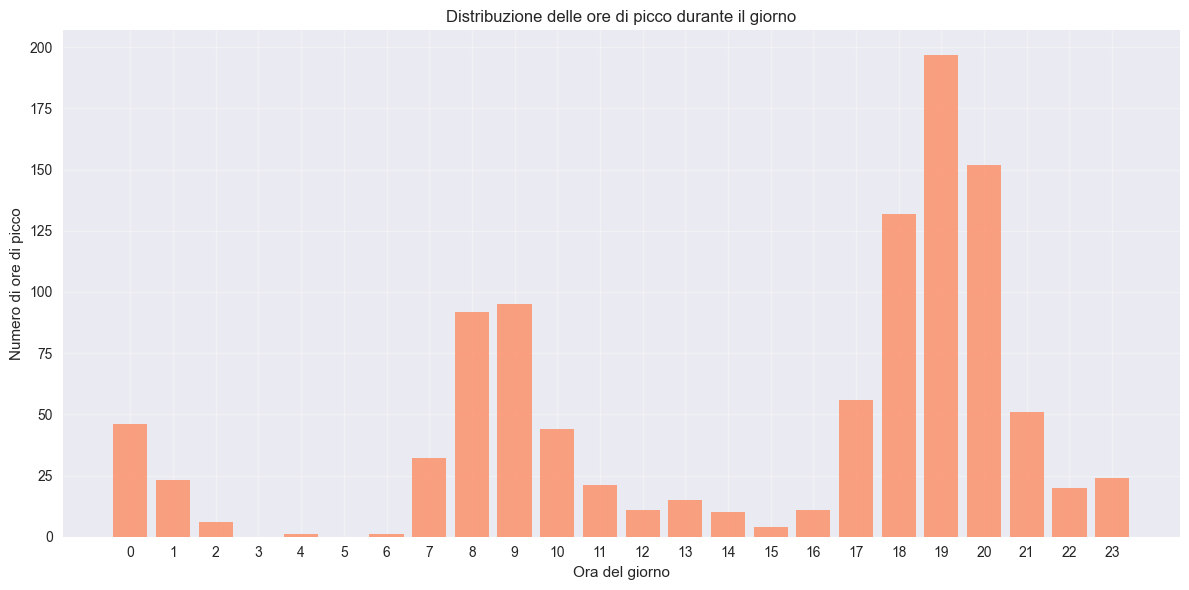


Ore più frequenti per i picchi di inquinamento:
Hour
0    46
1    23
2     6
4     1
6     1
Name: count, dtype: int64


In [13]:
# Analisi delle ore di picco
peak_hours_analysis = df_clean[df_clean['is_peak_hour'] == 1]
print(f"Concentrazione media durante le ore di picco: {peak_hours_analysis[target_pollutant].mean():.3f} mg/m³")
print(f"Concentrazione media durante le ore normali: {df_clean[df_clean['is_peak_hour'] == 0][target_pollutant].mean():.3f} mg/m³")

# Distribuzione oraria delle ore di picco
peak_hour_distribution = peak_hours_analysis['Hour'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.bar(peak_hour_distribution.index, peak_hour_distribution.values, alpha=0.7, color='coral')
plt.title('Distribuzione delle ore di picco durante il giorno')
plt.xlabel('Ora del giorno')
plt.ylabel('Numero di ore di picco')
plt.xticks(range(0, 24))
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. Analisi Settimanale della Qualità dell'Aria

In [14]:
# Calcolo della percentuale di ore con scarsa qualità dell'aria per settimana
weekly_poor_quality = df_clean.groupby('Week').agg({
    'quality_vs_overall': ['mean', 'sum', 'count'],
    target_pollutant: 'mean'
}).round(3)

# Flatten delle colonne
weekly_poor_quality.columns = ['poor_quality_pct', 'poor_quality_hours', 'total_hours', 'avg_concentration']

# Calcolo della media globale di ore con scarsa qualità
global_poor_quality_pct = df_clean['quality_vs_overall'].mean()

print(f"Percentuale globale di ore con scarsa qualità dell'aria: {global_poor_quality_pct:.3f} ({global_poor_quality_pct*100:.1f}%)")
print("\nPrime 10 settimane con analisi della qualità dell'aria:")
print(weekly_poor_quality.head(10))

Percentuale globale di ore con scarsa qualità dell'aria: 0.405 (40.5%)

Prime 10 settimane con analisi della qualità dell'aria:
      poor_quality_pct  poor_quality_hours  total_hours  avg_concentration
Week                                                                      
1                0.515                  85          165              2.420
2                0.573                  94          164              2.609
3                0.444                  60          135              2.325
4                0.042                   6          142              1.015
5                0.424                  70          165              2.290
6                0.506                  84          166              2.540
7                0.277                  46          166              1.709
8                0.424                  70          165              2.072
9                0.271                  45          166              1.733
10               0.308                  48     

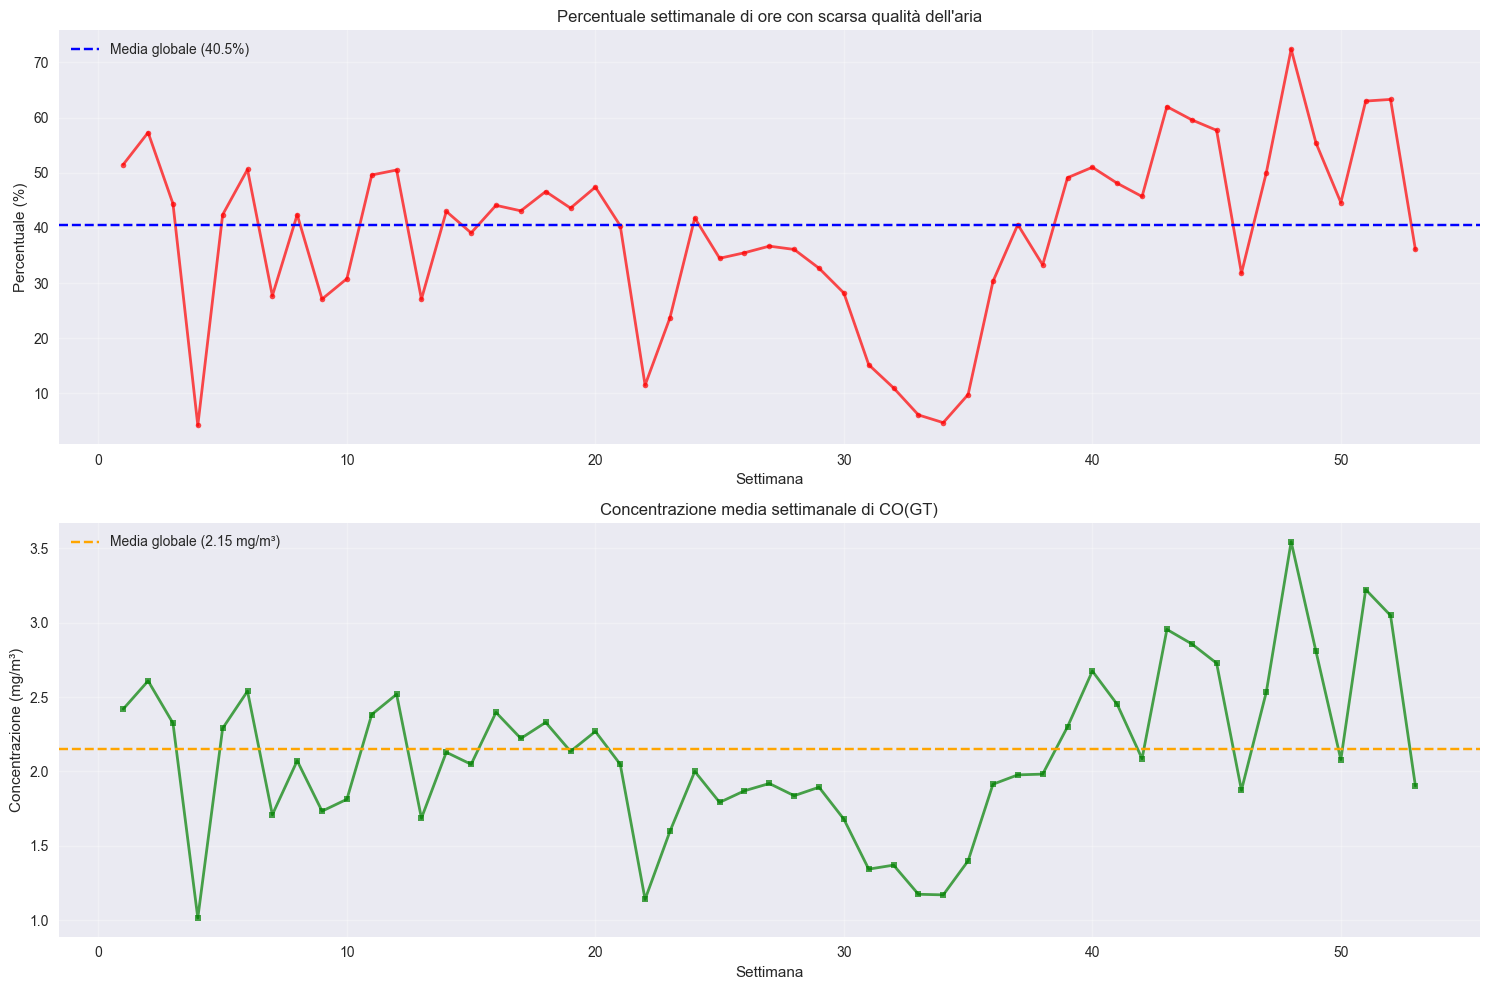

In [15]:
# Visualizzazione dell'andamento settimanale
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Percentuale di ore con scarsa qualità dell'aria per settimana
axes[0].plot(weekly_poor_quality.index, weekly_poor_quality['poor_quality_pct'] * 100, 
             marker='o', linewidth=2, markersize=4, color='red', alpha=0.7)
axes[0].axhline(y=global_poor_quality_pct * 100, color='blue', linestyle='--', 
                label=f'Media globale ({global_poor_quality_pct*100:.1f}%)')
axes[0].set_title('Percentuale settimanale di ore con scarsa qualità dell\'aria')
axes[0].set_xlabel('Settimana')
axes[0].set_ylabel('Percentuale (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Concentrazione media settimanale
axes[1].plot(weekly_poor_quality.index, weekly_poor_quality['avg_concentration'], 
             marker='s', linewidth=2, markersize=4, color='green', alpha=0.7)
axes[1].axhline(y=overall_mean, color='orange', linestyle='--', 
                label=f'Media globale ({overall_mean:.2f} mg/m³)')
axes[1].set_title(f'Concentrazione media settimanale di {target_pollutant}')
axes[1].set_xlabel('Settimana')
axes[1].set_ylabel('Concentrazione (mg/m³)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [16]:
# Identificazione delle settimane con qualità dell'aria più critica
worst_weeks = weekly_poor_quality.nlargest(5, 'poor_quality_pct')
best_weeks = weekly_poor_quality.nsmallest(5, 'poor_quality_pct')

print("Top 5 settimane con PEGGIORE qualità dell'aria:")
print(worst_weeks[['poor_quality_pct', 'avg_concentration']])

print("\nTop 5 settimane con MIGLIORE qualità dell'aria:")
print(best_weeks[['poor_quality_pct', 'avg_concentration']])

# Confronto con la media globale
above_average_weeks = (weekly_poor_quality['poor_quality_pct'] > global_poor_quality_pct).sum()
total_weeks = len(weekly_poor_quality)

print(f"\nSettimane sopra la media globale: {above_average_weeks}/{total_weeks} ({above_average_weeks/total_weeks*100:.1f}%)")

Top 5 settimane con PEGGIORE qualità dell'aria:
      poor_quality_pct  avg_concentration
Week                                     
48               0.724              3.545
52               0.633              3.049
51               0.630              3.223
43               0.620              2.955
44               0.596              2.858

Top 5 settimane con MIGLIORE qualità dell'aria:
      poor_quality_pct  avg_concentration
Week                                     
4                0.042              1.015
34               0.047              1.170
33               0.061              1.174
35               0.098              1.399
32               0.110              1.370

Settimane sopra la media globale: 29/53 (54.7%)


## 8. Preparazione dei Dati per il Machine Learning

In [17]:
# Selezione delle features per il modello
# Includiamo variabili meteorologiche e temporali come predittori
feature_columns = ['Hour', 'Weekday', 'Month']

# Aggiungiamo variabili meteorologiche se disponibili
weather_columns = ['T', 'RH', 'AH']  # Temperatura, Umidità Relativa, Umidità Assoluta
available_weather = [col for col in weather_columns if col in df_clean.columns]
feature_columns.extend(available_weather)

# Aggiungiamo altri inquinanti come features
other_pollutants = ['NO2(GT)', 'NOx(GT)', 'C6H6(GT)']
available_pollutants = [col for col in other_pollutants if col in df_clean.columns and col != target_pollutant]
feature_columns.extend(available_pollutants)

for i, feature in enumerate(feature_columns, 1):
    print(f"{i}. {feature}")

# Rimozione dei valori mancanti
df_ml = df_clean[feature_columns + ['quality_vs_overall']].dropna()
print(f"\nDimensioni del dataset per ML: {df_ml.shape}")

Features selezionate per il modello:
1. Hour
2. Weekday
3. Month
4. T
5. RH
6. AH
7. NO2(GT)
8. NOx(GT)
9. C6H6(GT)

Dimensioni del dataset per ML: (6941, 10)


In [18]:
# Preparazione di X e y
X = df_ml[feature_columns]
y = df_ml['quality_vs_overall']

# Split del dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimensioni training set: {X_train.shape}")
print(f"Dimensioni test set: {X_test.shape}")
print(f"\nDistribuzione classi nel training set:")
print(y_train.value_counts(normalize=True))
print(f"\nDistribuzione classi nel test set:")
print(y_test.value_counts(normalize=True))

Dimensioni training set: (5552, 9)
Dimensioni test set: (1389, 9)

Distribuzione classi nel training set:
quality_vs_overall
0    0.584474
1    0.415526
Name: proportion, dtype: float64

Distribuzione classi nel test set:
quality_vs_overall
0    0.584593
1    0.415407
Name: proportion, dtype: float64


## 9. Modello 1: Decision Tree

### 9.1 Training e Ottimizzazione

In [19]:
# Implementazione del Decision Tree con Grid Search
print("=== DECISION TREE CLASSIFIER ===")

# Parametri per la Grid Search
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Grid Search
dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, dt_params, cv=5, scoring='accuracy', n_jobs=-1)
dt_grid.fit(X_train, y_train)

print(f"Migliori parametri: {dt_grid.best_params_}")
print(f"Miglior score CV: {dt_grid.best_score_:.4f}")

# Modello finale
best_dt = dt_grid.best_estimator_

=== DECISION TREE CLASSIFIER ===
Migliori parametri: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Miglior score CV: 0.9269
Migliori parametri: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Miglior score CV: 0.9269


In [20]:
# Predizioni e valutazione Decision Tree
y_pred_dt = best_dt.predict(X_test)
y_pred_proba_dt = best_dt.predict_proba(X_test)[:, 1]

print("=== RISULTATI DECISION TREE ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_dt):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_dt):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, 
                          target_names=['Buona qualità', 'Scarsa qualità']))

=== RISULTATI DECISION TREE ===
Accuracy: 0.9309
Precision: 0.9197
Recall: 0.9133
F1-Score: 0.9165

Classification Report:
                precision    recall  f1-score   support

 Buona qualità       0.94      0.94      0.94       812
Scarsa qualità       0.92      0.91      0.92       577

      accuracy                           0.93      1389
     macro avg       0.93      0.93      0.93      1389
  weighted avg       0.93      0.93      0.93      1389



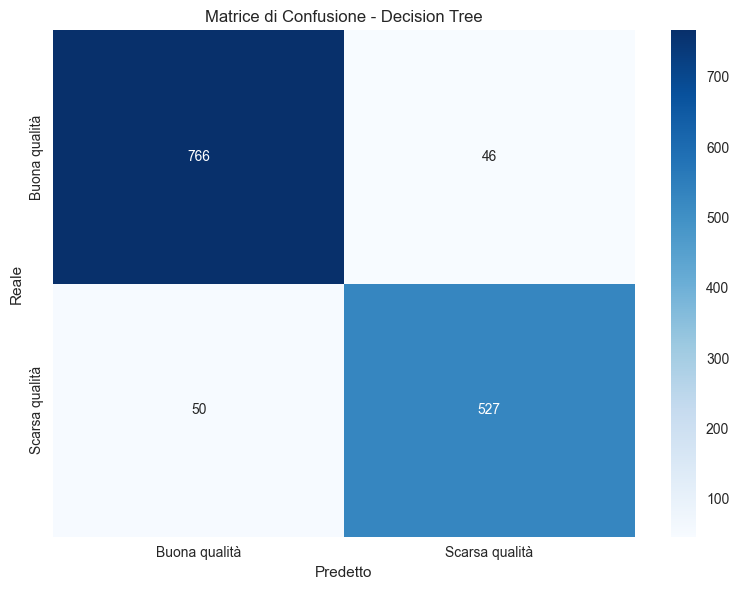

In [21]:
# Visualizzazione della matrice di confusione per Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Buona qualità', 'Scarsa qualità'],
            yticklabels=['Buona qualità', 'Scarsa qualità'])
plt.title('Matrice di Confusione - Decision Tree')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.tight_layout()
plt.show()

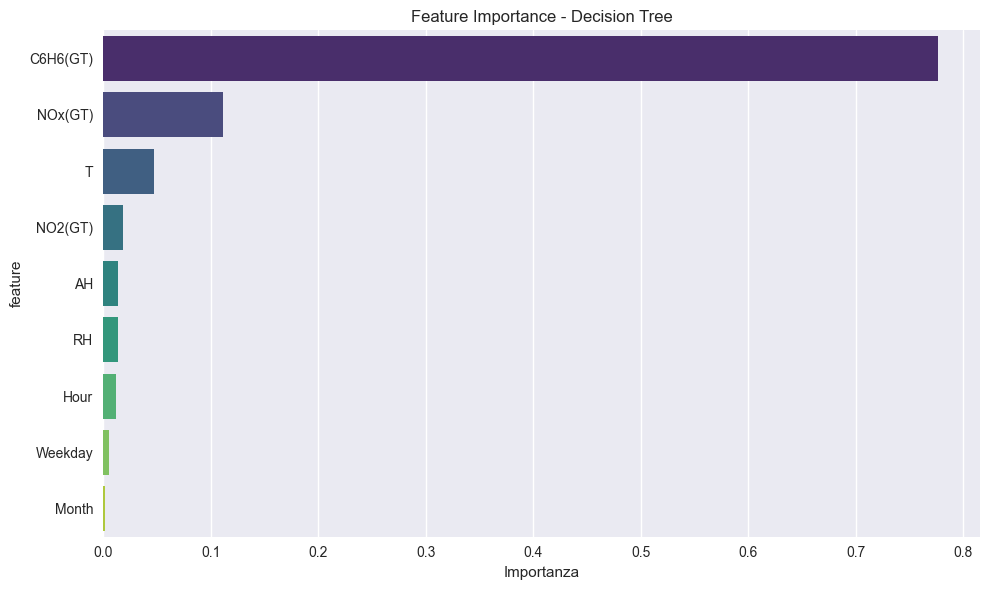

Feature Importance (Decision Tree):
    feature  importance
8  C6H6(GT)    0.776868
7   NOx(GT)    0.111428
3         T    0.047171
6   NO2(GT)    0.018227
5        AH    0.013745
4        RH    0.013407
0      Hour    0.011968
1   Weekday    0.005290
2     Month    0.001897


In [22]:
# Feature importance del Decision Tree
feature_importance_dt = pd.DataFrame({
    'feature': feature_columns,
    'importance': best_dt.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_dt, y='feature', x='importance', palette='viridis')
plt.title('Feature Importance - Decision Tree')
plt.xlabel('Importanza')
plt.tight_layout()
plt.show()

print("Feature Importance (Decision Tree):")
print(feature_importance_dt)

### 9.2 Visualizzazione dell'Albero di Decisione

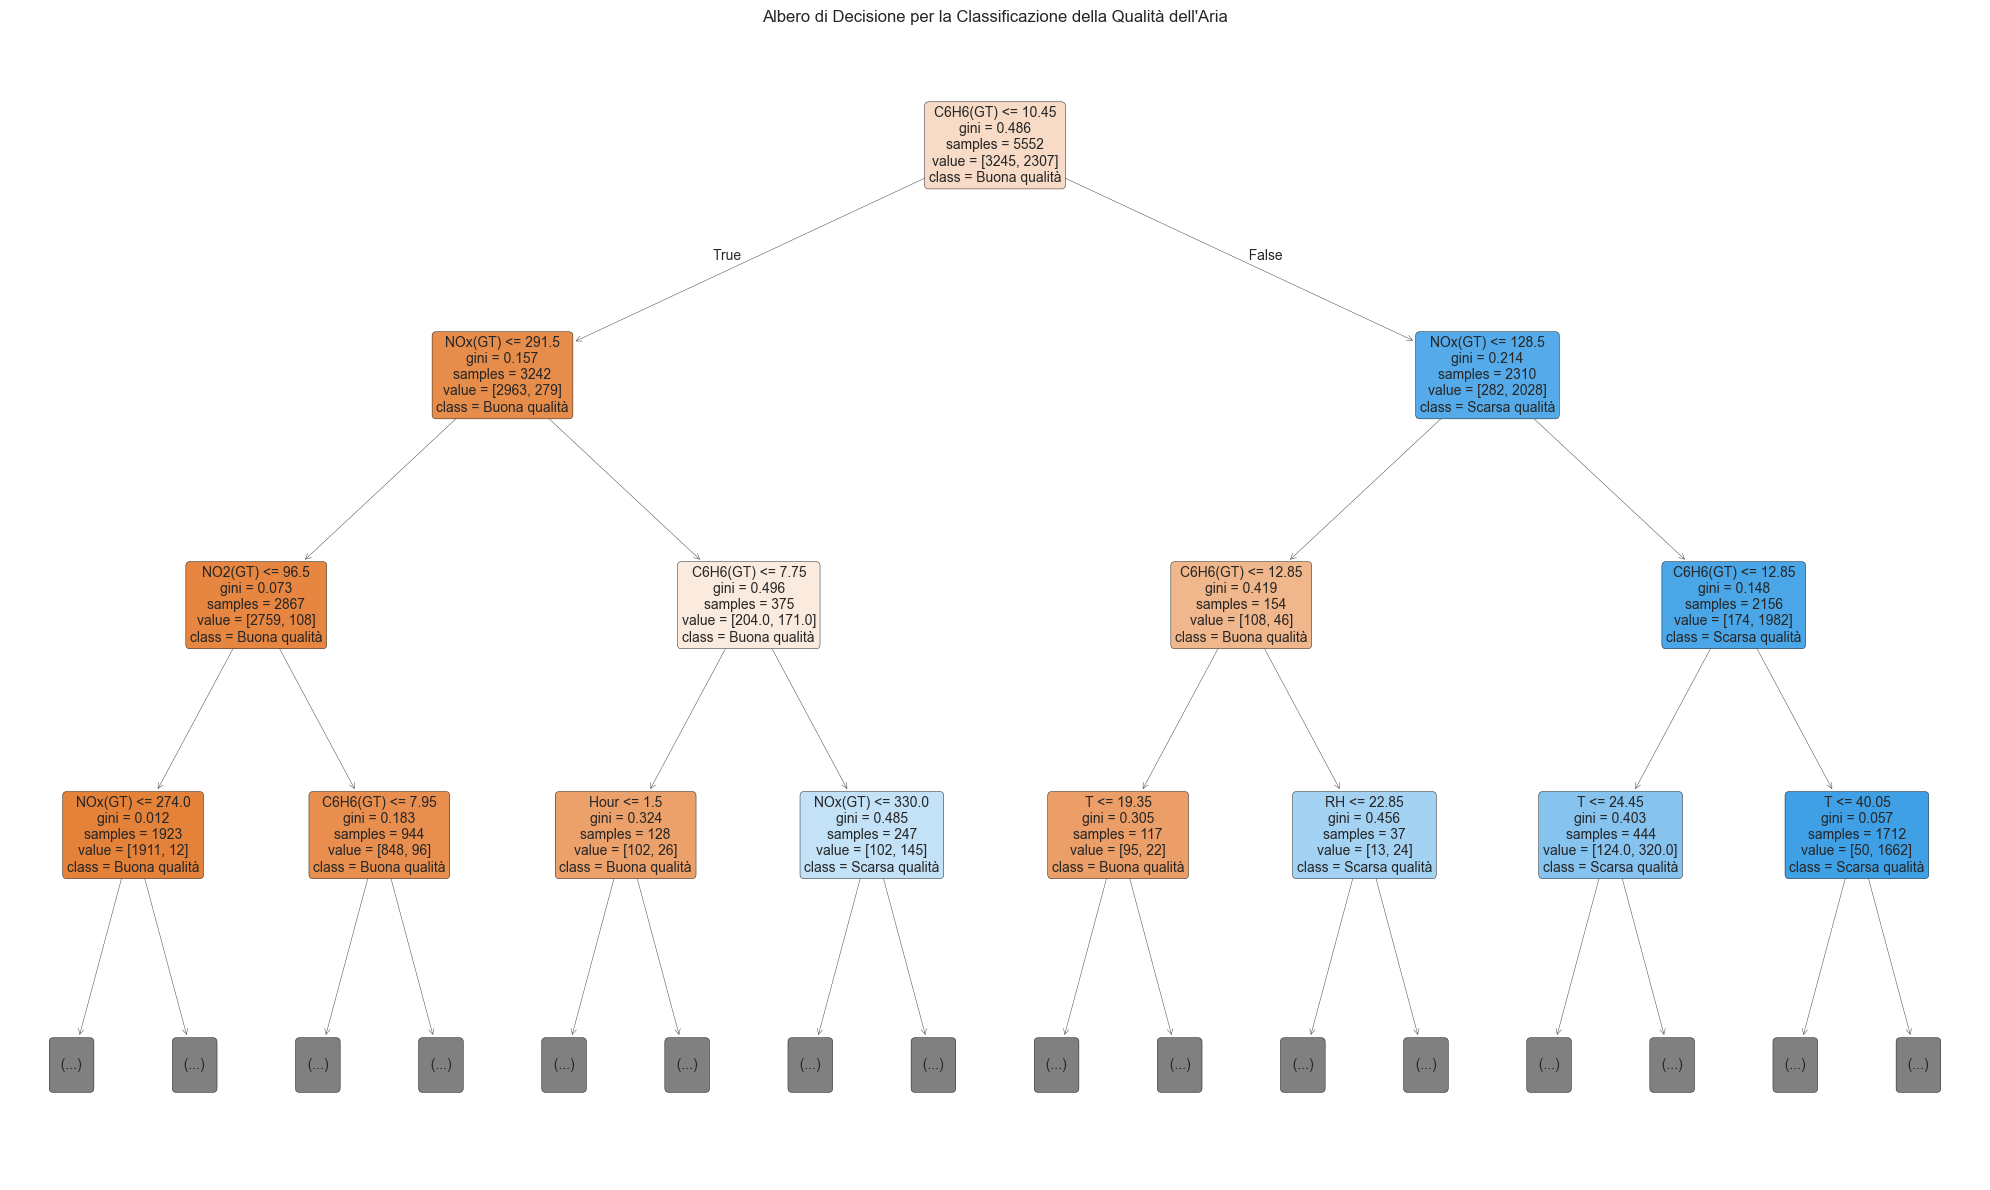

In [23]:
# Visualizzazione dell'albero di decisione (versione semplificata)
plt.figure(figsize=(20, 12))
plot_tree(best_dt, 
          feature_names=feature_columns,
          class_names=['Buona qualità', 'Scarsa qualità'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=3)  # Limitiamo la profondità per la visualizzazione
plt.title('Albero di Decisione per la Classificazione della Qualità dell\'Aria')
plt.tight_layout()
plt.show()

## 10. Modello 2: Neural Network (MLP)

### 10.1 Preprocessing per Neural Network

In [24]:
# Standardizzazione delle features per la Neural Network
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features standardizzate per la Neural Network")
print(f"Media delle features di training: {X_train_scaled.mean(axis=0).round(3)}")
print(f"Std delle features di training: {X_train_scaled.std(axis=0).round(3)}")

Features standardizzate per la Neural Network
Media delle features di training: [-0.  0.  0. -0. -0. -0. -0.  0. -0.]
Std delle features di training: [1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 10.2 Training e Ottimizzazione MLP

In [25]:
# Implementazione della Neural Network con Grid Search (parametri ridotti per velocità)
print("=== NEURAL NETWORK (MLP) CLASSIFIER ===")

# Parametri ridotti per la Grid Search (più veloce)
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu'],
    'alpha': [0.001, 0.01],
    'learning_rate': ['constant']
}

# Grid Search con CV ridotto
mlp = MLPClassifier(random_state=42, max_iter=500)
mlp_grid = GridSearchCV(mlp, mlp_params, cv=3, scoring='accuracy', n_jobs=-1)
mlp_grid.fit(X_train_scaled, y_train)

print(f"Migliori parametri: {mlp_grid.best_params_}")
print(f"Miglior score CV: {mlp_grid.best_score_:.4f}")

# Modello finale
best_mlp = mlp_grid.best_estimator_

=== NEURAL NETWORK (MLP) CLASSIFIER ===
Migliori parametri: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}
Miglior score CV: 0.9398


In [32]:
# Predizioni e valutazione Neural Network
y_pred_mlp = best_mlp.predict(X_test_scaled)
y_pred_proba_mlp = best_mlp.predict_proba(X_test_scaled)[:, 1]

print("=== RISULTATI NEURAL NETWORK ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_mlp):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_mlp):.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_mlp, 
                          target_names=['Buona qualità', 'Scarsa qualità']))

=== RISULTATI NEURAL NETWORK ===
Accuracy: 0.9446
Precision: 0.9464
Recall: 0.9185
F1-Score: 0.9323

Classification Report:
                precision    recall  f1-score   support

 Buona qualità       0.94      0.96      0.95       812
Scarsa qualità       0.95      0.92      0.93       577

      accuracy                           0.94      1389
     macro avg       0.94      0.94      0.94      1389
  weighted avg       0.94      0.94      0.94      1389



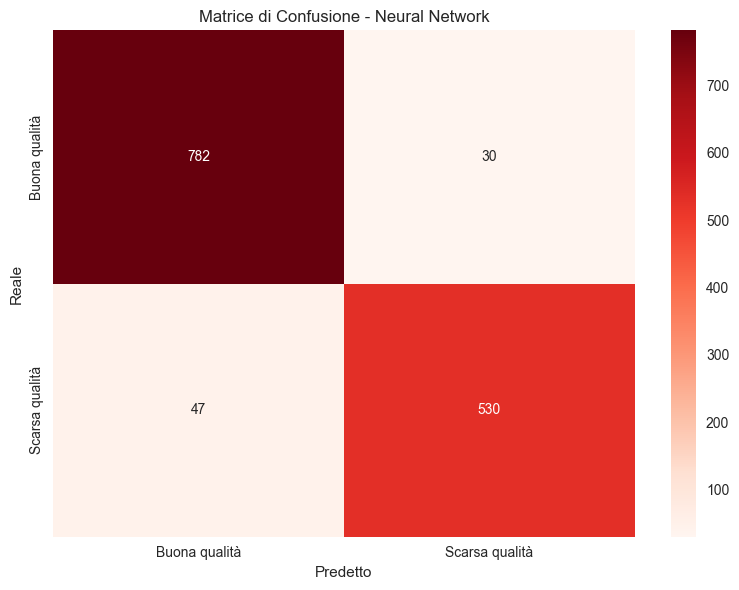

In [27]:
# Visualizzazione della matrice di confusione per Neural Network
cm_mlp = confusion_matrix(y_test, y_pred_mlp)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Buona qualità', 'Scarsa qualità'],
            yticklabels=['Buona qualità', 'Scarsa qualità'])
plt.title('Matrice di Confusione - Neural Network')
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.tight_layout()
plt.show()

## 11. Confronto dei Modelli e Analisi Finale

=== CONFRONTO FINALE DEI MODELLI ===
          Modello  Accuracy  Precision  Recall  F1-Score
0   Decision Tree    0.9309     0.9197  0.9133    0.9165
1  Neural Network    0.9446     0.9464  0.9185    0.9323


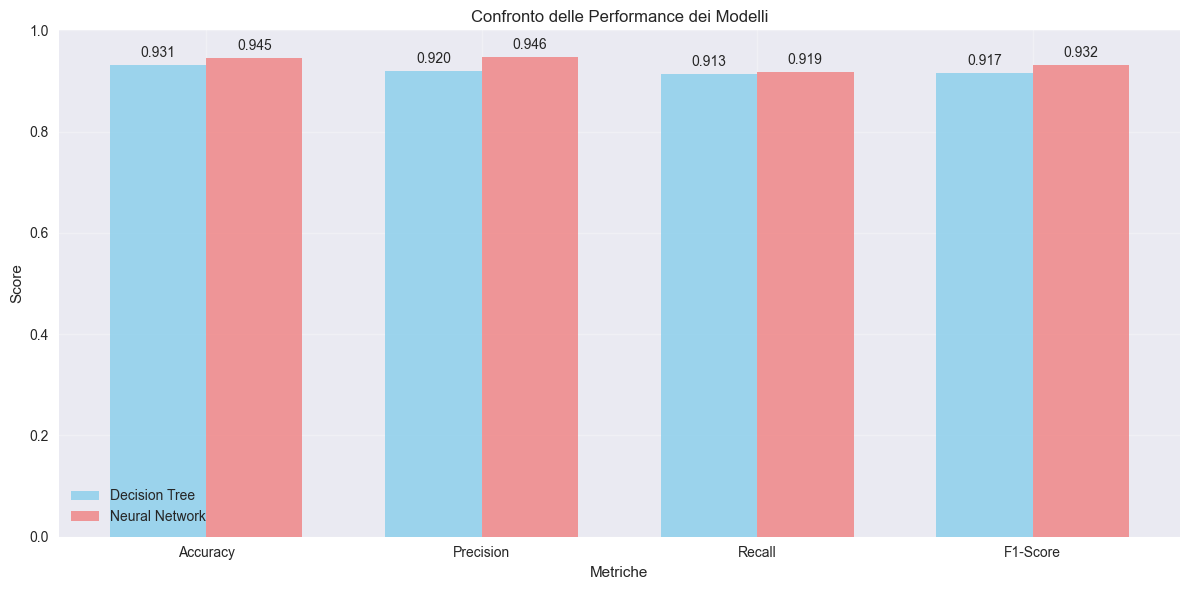

In [28]:
# Confronto delle performance dei modelli
models_comparison = pd.DataFrame({
    'Modello': ['Decision Tree', 'Neural Network'],
    'Accuracy': [accuracy_score(y_test, y_pred_dt), accuracy_score(y_test, y_pred_mlp)],
    'Precision': [precision_score(y_test, y_pred_dt), precision_score(y_test, y_pred_mlp)],
    'Recall': [recall_score(y_test, y_pred_dt), recall_score(y_test, y_pred_mlp)],
    'F1-Score': [f1_score(y_test, y_pred_dt), f1_score(y_test, y_pred_mlp)]
})

print("=== CONFRONTO FINALE DEI MODELLI ===")
print(models_comparison.round(4))

# Visualizzazione del confronto
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
dt_scores = [accuracy_score(y_test, y_pred_dt), precision_score(y_test, y_pred_dt), 
             recall_score(y_test, y_pred_dt), f1_score(y_test, y_pred_dt)]
mlp_scores = [accuracy_score(y_test, y_pred_mlp), precision_score(y_test, y_pred_mlp),
              recall_score(y_test, y_pred_mlp), f1_score(y_test, y_pred_mlp)]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, dt_scores, width, label='Decision Tree', alpha=0.8, color='skyblue')
plt.bar(x + width/2, mlp_scores, width, label='Neural Network', alpha=0.8, color='lightcoral')

plt.xlabel('Metriche')
plt.ylabel('Score')
plt.title('Confronto delle Performance dei Modelli')
plt.xticks(x, metrics)
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)

# Aggiunta dei valori sulle barre
for i, (dt_score, mlp_score) in enumerate(zip(dt_scores, mlp_scores)):
    plt.text(i - width/2, dt_score + 0.01, f'{dt_score:.3f}', ha='center', va='bottom')
    plt.text(i + width/2, mlp_score + 0.01, f'{mlp_score:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 12. Analisi delle Predizioni e Insights

In [29]:
# Analisi degli errori di classificazione
# Identificazione dei casi più difficili da classificare

# Creazione di un DataFrame con i risultati
results_df = pd.DataFrame({
    'actual': y_test,
    'dt_pred': y_pred_dt,
    'mlp_pred': y_pred_mlp,
    'dt_proba': y_pred_proba_dt,
    'mlp_proba': y_pred_proba_mlp
})

# Casi dove entrambi i modelli sbagliano
both_wrong = results_df[(results_df['actual'] != results_df['dt_pred']) & 
                       (results_df['actual'] != results_df['mlp_pred'])]

# Casi dove solo un modello sbaglia
only_dt_wrong = results_df[(results_df['actual'] != results_df['dt_pred']) & 
                          (results_df['actual'] == results_df['mlp_pred'])]

only_mlp_wrong = results_df[(results_df['actual'] == results_df['dt_pred']) & 
                           (results_df['actual'] != results_df['mlp_pred'])]

print("=== ANALISI DEGLI ERRORI ===")
print(f"Casi dove entrambi i modelli sbagliano: {len(both_wrong)} ({len(both_wrong)/len(results_df)*100:.1f}%)")
print(f"Casi dove solo Decision Tree sbaglia: {len(only_dt_wrong)} ({len(only_dt_wrong)/len(results_df)*100:.1f}%)")
print(f"Casi dove solo Neural Network sbaglia: {len(only_mlp_wrong)} ({len(only_mlp_wrong)/len(results_df)*100:.1f}%)")

# Accordo tra i modelli
agreement = (results_df['dt_pred'] == results_df['mlp_pred']).mean()
print(f"\nAccordo tra i modelli: {agreement:.3f} ({agreement*100:.1f}%)")

=== ANALISI DEGLI ERRORI ===
Casi dove entrambi i modelli sbagliano: 48 (3.5%)
Casi dove solo Decision Tree sbaglia: 48 (3.5%)
Casi dove solo Neural Network sbaglia: 29 (2.1%)

Accordo tra i modelli: 0.945 (94.5%)
